In [5]:
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm

from matplotlib import cm as CM
from scipy import stats

from scipy.interpolate import griddata

from scipy import ndimage
import numpy as np
import matplotlib.tri as tri
import utils
import sys
import seaborn as sns


In [6]:
#checkm and gstawk are used for computing contamination, incompletion, and N50
checkm = "../precomputed_results/25-50-checkm.txt"
second = "../precomputed_results/25-50-gstawk.txt"

#species bin folders for Pasolli et al. (2019)
sgb_folders = ["../precomputed_results/"]
genome_dict = dict()

plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'font.family':'arial'})
cm = 1/2.54  # centimeters in inches
downsample = 1

#Use sourmash max-contain instead of mash
anim_sourmash = False

gridsize=15

vmax = 98.5
vmin =  96.5
mincnt = 20

#Parse big checkm log. 
for line in open(checkm, 'r'):
    if line[0] == '-' or "Contamination" in line or line[0] == '[' or len(line.strip()) == 0:
        continue
    spl = line.split()
    spl_g = spl[0].split('/')[-1]
    genome = spl_g + '.fa'
    completeness = 100 - float(spl[-3])
    contam = float(spl[-2])
    genome_dict[genome] = [completeness,contam]

#Parse gstawk n50s. 
for line in open(second, 'r'):
    if 'assembly' in line:
        continue
    spl = line.split('\t')
    spl_g = spl[0].split('/')[-1]
    if 'gstawk' in second:
        genome = spl_g
        N50 = int(spl[-2])
        if genome in genome_dict:
            genome_dict[genome].append(N50)
    else:
        genome = spl_g + '.fa'
        contam_portion  = float(spl[-2])
        if genome in genome_dict:
            genome_dict[genome].append(contam_portion)

dist_mat_skani = dict()
dist_mat_skani_clf = dict()
dist_mat_fastani = dict()
dist_mat_mash = dict()
dist_mat_anim = dict()
dist_mat_sourmash = dict()
dist_mat_sour_norm = dict()
skani = []
skani_clf = []
anim_ani = []
low = 93
high = 100

for folder in sgb_folders:
    #results are distances matrices in the files
    #anim_[ID], skani_[ID], fastani_[ID], mash_[ID]  
    
    anim_folders = glob.glob(folder + "/25-50/anim_*")
    for anim_folder in anim_folders:
        num = anim_folder.split('_')[-1]
        anim_res = anim_folder + "/ANIm_percentage_identity.tab"
        skani_res = folder + "/25-50/no-learn-skani_" + num
        skani_res_clf = folder + "/25-50/skani_" + num
        fastani_res = folder + "/25-50/fastani_" + num + ".matrix"
        mash_res = folder + "/25-50/mash_" + num
        sourmash_res_norm = folder + "/25-50/sour-normal_" + num
        sourmash_res = folder + "/25-50/sour_" + num

        anim_mat = utils.parse_matrix(anim_res)
        skani_mat = utils.parse_matrix(skani_res)
        skani_clf_mat = utils.parse_matrix(skani_res_clf)
        fastani_mat = utils.parse_matrix(fastani_res)
        mash_mat = utils.parse_matrix(mash_res)
        sourmash_mat = utils.parse_matrix(sourmash_res)
        sour_norm_mat = utils.parse_matrix(sourmash_res_norm)

        #Keep the ANI calculation if the ANIm predicated ANI is > 99%
        for (ref1,ref2) in anim_mat:
            key = (ref1,ref2)
            rkey = (ref2,ref1)
            n50_1 = genome_dict[ref1][-1]
            n50_2 = genome_dict[ref2][-1]
            if n50_1 < n50_2:
                n50_x = np.log(n50_1)
                n50_y = np.log(n50_2)
            else:
                n50_x = np.log(n50_2)
                n50_y = np.log(n50_1)
            if anim_mat[key] > low and anim_mat[key] < high:
                dist_mat_anim[key] = anim_mat[key]
                if key in skani_mat:
                    x = skani_mat[key]
                    x_clf = skani_clf_mat[key]
                    dist_mat_skani_clf[key] = x_clf
                    dist_mat_skani[key] = x
                elif rkey in skani_mat:
                    x = skani_mat[rkey]
                    x_clf = skani_clf_mat[rkey]
                    dist_mat_skani_clf[key] = x_clf
                    dist_mat_skani[key] = x
                if key in fastani_mat:
                    dist_mat_fastani[key] = fastani_mat[key]
                elif rkey in fastani_mat:
                    dist_mat_fastani[key] = fastani_mat[rkey]
                if key in mash_mat:
                    dist_mat_mash[key] = mash_mat[key]
                elif rkey in mash_mat:
                    dist_mat_mash[key] = mash_mat[rkey]
                if key in sourmash_mat:
                    dist_mat_sourmash[key] = sourmash_mat[key]
                    dist_mat_sour_norm[key] = sour_norm_mat[key]
                elif rkey in sourmash_mat:
                    dist_mat_sourmash[key] = sourmash_mat[rkey]
                    dist_mat_sour_norm[key] = sour_norm_mat[rkey]
                    
for key in dist_mat_anim:
    if key in dist_mat_skani:
        anim_ani.append(dist_mat_anim[key])
        skani.append(dist_mat_skani[key] - dist_mat_anim[key])
        skani_clf.append(dist_mat_skani_clf[key] - dist_mat_anim[key])
                    
print(len(skani))

156406


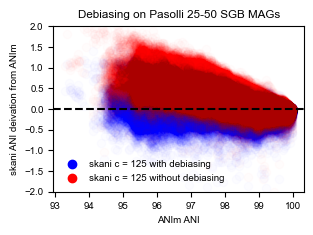

In [13]:
fig = plt.figure(figsize=(8*cm, 6*cm))
plt.plot(anim_ani, skani_clf, 'o', alpha = 0.01, c = 'blue', label = 'skani c = 125 with debiasing')
plt.plot(anim_ani, skani, 'o', alpha = 0.01, c = 'red', label = 'skani c = 125 without debiasing')
#plt.axhline(y=0.0, color='black', linestyle='-')
leg = plt.legend(frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("ANIm ANI")
plt.ylabel("skani ANI deivation from ANIm")
plt.ylim([-2,2])

plt.axhline(y=0.0, color='black', linestyle='--')
plt.title("Debiasing on Pasolli 25-50 SGB MAGs")

plt.tight_layout()
plt.savefig("../final_figures/debias_skani.png", dpi = 200,bbox_inches='tight',pad_inches=0,)
    #plt.boxplot([skani_af_diff, skanic60_af_diff, fastani_af_diff], whis = [1.0,99.0])